In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from PIL import Image, ImageDraw
from tqdm import tqdm

In [4]:
def count_files_in_dirs(dirs):
    total_files = 0
    for dir in dirs:
        if os.path.isdir(dir):
            files = os.listdir(dir)
            total_files += len(files)
    return total_files

In [5]:
class CustomDataset(Dataset):
    def __init__(self, real_dirs, fake_dirs, transform=None):
        self.image_list = []
        self.label_list = []
        self.transform = transform
        
        for directory in real_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(0)
                    
        for directory in fake_dirs:
            for filename in os.listdir(directory):
                if filename.endswith('.jpg'):
                    self.image_list.append(os.path.join(directory, filename))
                    self.label_list.append(1)
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index]).convert('RGB')
        image = image.resize((224, 224))
        label = self.label_list[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_sample_metadata = pd.read_json('output/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [7]:
input_dir = 'output/deepfake-detection-challenge/train_sample_videos/'
real_dirs = []
fake_dirs = []
for i in range(len(train_sample_metadata)):
    fn = train_sample_metadata.index[i]
    label = train_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [9]:
print(count_files_in_dirs(real_dirs))
print(count_files_in_dirs(fake_dirs))

2174
8557


In [11]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = CustomDataset(real_dirs, fake_dirs, transform=train_transforms)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
len(train_dataset)

10731

In [14]:
test_sample_metadata = pd.read_json('output/deepfake-detection-challenge/dfdc_train_part_0_aug1/metadata.json').T
test_sample_metadata.head()

,label,split,original
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
vpmyeepbep.mp4,REAL,train,NaN
fzvpbrzssi.mp4,REAL,train,NaN
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [15]:
input_dir = 'output/deepfake-detection-challenge/dfdc_train_part_0_aug1/'
real_dirs = []
fake_dirs = []
for i in range(len(test_sample_metadata)):
    fn = test_sample_metadata.index[i]
    label = test_sample_metadata.iloc[i,0]
    fn_dir = input_dir+fn+'/'
    if label=='REAL':
        real_dirs.append(fn_dir)
    else:
        fake_dirs.append(fn_dir)

In [16]:
print(count_files_in_dirs(real_dirs))
print(count_files_in_dirs(fake_dirs))

3811
21309


In [17]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = CustomDataset(real_dirs, fake_dirs, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
len(test_dataset)

25120

In [103]:
# model = EfficientNet.from_pretrained('efficientnet-b0')
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Stem
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU(inplace=True)
        # Blocks
        self.blocks = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 32, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
            ),
        )
        # Head
        self.conv2 = nn.Conv2d(32, 128, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        # Blocks
        x = self.blocks(x)
        # Head
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MyModel()

In [21]:
import torchvision.models as models
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)
for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [41]:
import timm
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=2)
num_ftrs = model.classif.in_features
model.classif = nn.Linear(num_ftrs, 1)
for param in model.parameters():
    param.requires_grad = False
for param in model.classif.parameters():
    param.requires_grad = True

In [22]:
def display_model(model):
    # Check number of parameters 
    summary_dict = {}
    num_params = 0
    summary_str = ['='*80]

    for module_name, module in model.named_children():
        summary_count = 0
        for name, param in module.named_parameters():
            if(param.requires_grad):
                summary_count += param.numel()
                num_params += param.numel()
        summary_dict[module_name] = [summary_count]
        summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

    summary_dict['total'] = [num_params]

    # print summary string
    summary_str += ['='*80]
    summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
    print('\n'.join(summary_str))

    # print model structure
    print(model)

In [23]:
display_model(model)
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.summary()

- _conv_stem                               :                 0                 
- _bn0                                     :                 0                 
- _blocks                                  :                 0                 
- _conv_head                               :                 0                 
- _bn1                                     :                 0                 
- _avg_pooling                             :                 0                 
- _dropout                                 :                 0                 
- _fc                                      :                1281               
- _swish                                   :                 0                 
--Total                                    :            1281 params            --
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001,

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []
    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:
        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
             precision: precision score of predicted labels
             recall: recall score of predicted labels
             f1: f1 score of predicted labels
    """
    model.eval()
    losses = []
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:
        images, labels = images.to(device), labels.view(-1, 1).to(device).float()
        with torch.no_grad():
            output = model(images)
            preds = torch.round(torch.sigmoid(output)).type(torch.int)
            loss = criterion(output, labels)
            losses.append(loss.item())
            predicted_labels.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())
            correct += (preds == labels).sum().item()
            total += len(labels)
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
    print('Precision: {0:.4f}'.format(precision))
    print('Recall: {0:.4f}'.format(recall))
    print('F1 Score: {0:.4f}'.format(f1))

    return mean_accuracy, test_loss, precision, recall, f1

In [104]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [105]:
train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_interval = 5

# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1):
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    scheduler.step()
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    if epoch==0 or (epoch+1)%test_interval==0:
        print('Evaluating Network')

        train_accuracy, _, _, _, _ = test(train_loader, model, criterion)
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss, test_precision, test_recall, test_f1 = test(test_loader, model, criterion)
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')


loss: 0.395: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:38<00:00,  2.12it/s]


Loss for Training on epoch 0 is 0.49083346128463745 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:04<00:00,  2.70it/s]


Mean Accuracy: 0.7974
Avg loss: 0.4907892818252246
Precision: 0.7975
Recall: 0.9999
F1 Score: 0.8873
Training accuracy on epoch 0 is 0.7974093747087876 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 785/785 [03:25<00:00,  3.83it/s]

Training ...:   7%|████▍                                                             | 1/15 [08:08<1:54:03, 488.79s/it]

Mean Accuracy: 0.8483
Avg loss: 0.43529851897886607
Precision: 0.8483
Recall: 1.0000
F1 Score: 0.9179
Testing accuracy on epoch 0 is 0.8482882165605096 



loss: 0.496: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:01<00:00,  2.76it/s]

Training ...:  13%|█████████                                                           | 2/15 [10:10<59:07, 272.85s/it]

Loss for Training on epoch 1 is 0.4876500070095062 



loss: 0.522: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:01<00:00,  2.76it/s]

Training ...:  20%|█████████████▌                                                      | 3/15 [12:12<40:46, 203.84s/it]

Loss for Training on epoch 2 is 0.4839060604572296 



loss: 0.470: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:07<00:00,  2.64it/s]

Training ...:  27%|██████████████████▏                                                 | 4/15 [14:19<31:49, 173.61s/it]

Loss for Training on epoch 3 is 0.4791363775730133 



loss: 0.529: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:57<00:00,  2.85it/s]


Loss for Training on epoch 4 is 0.47545337677001953 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [02:03<00:00,  2.72it/s]


Mean Accuracy: 0.7982
Avg loss: 0.4698007445605028
Precision: 0.7998
Recall: 0.9961
F1 Score: 0.8873
Training accuracy on epoch 4 is 0.798154878389712 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 785/785 [01:41<00:00,  7.72it/s]

Training ...:  33%|██████████████████████▋                                             | 5/15 [20:03<39:10, 235.02s/it]

Mean Accuracy: 0.8483
Avg loss: 0.4237107172181272
Precision: 0.8483
Recall: 1.0000
F1 Score: 0.9179
Testing accuracy on epoch 4 is 0.8482882165605096 



loss: 0.414: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:55<00:00,  2.92it/s]

Training ...:  40%|███████████████████████████▏                                        | 6/15 [21:58<29:08, 194.28s/it]

Loss for Training on epoch 5 is 0.46741050481796265 



loss: 0.599: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:02<00:00,  2.74it/s]

Training ...:  47%|███████████████████████████████▋                                    | 7/15 [24:01<22:47, 170.93s/it]

Loss for Training on epoch 6 is 0.46839016675949097 



loss: 0.641: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:00<00:00,  2.78it/s]

Training ...:  53%|████████████████████████████████████▎                               | 8/15 [26:02<18:04, 154.97s/it]

Loss for Training on epoch 7 is 0.4669790267944336 



loss: 0.213: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:58<00:00,  2.84it/s]

Training ...:  60%|████████████████████████████████████████▊                           | 9/15 [28:00<14:21, 143.55s/it]

Loss for Training on epoch 8 is 0.46214377880096436 



loss: 0.408: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:57<00:00,  2.87it/s]


Loss for Training on epoch 9 is 0.46236443519592285 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [01:57<00:00,  2.86it/s]


Mean Accuracy: 0.8023
Avg loss: 0.45948958503348486
Precision: 0.8056
Recall: 0.9911
F1 Score: 0.8888
Training accuracy on epoch 9 is 0.8022551486347964 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 785/785 [01:32<00:00,  8.48it/s]

Training ...:  67%|████████████████████████████████████████████▋                      | 10/15 [33:28<16:41, 200.34s/it]

Mean Accuracy: 0.8492
Avg loss: 0.438312192028685
Precision: 0.8499
Recall: 0.9987
F1 Score: 0.9183
Testing accuracy on epoch 9 is 0.8492436305732484 



loss: 0.716: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:57<00:00,  2.85it/s]

Training ...:  73%|█████████████████████████████████████████████████▏                 | 11/15 [35:26<11:40, 175.09s/it]

Loss for Training on epoch 10 is 0.46433740854263306 



loss: 0.431: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:01<00:00,  2.77it/s]

Training ...:  80%|█████████████████████████████████████████████████████▌             | 12/15 [37:27<07:56, 158.72s/it]

Loss for Training on epoch 11 is 0.46268999576568604 



loss: 0.219: 100%|███████████████████████████████████████████████████████████████████| 336/336 [02:01<00:00,  2.76it/s]

Training ...:  87%|██████████████████████████████████████████████████████████         | 13/15 [39:29<04:55, 147.53s/it]

Loss for Training on epoch 12 is 0.46146515011787415 



loss: 0.357: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:56<00:00,  2.88it/s]

Training ...:  93%|██████████████████████████████████████████████████████████████▌    | 14/15 [41:25<02:18, 138.24s/it]

Loss for Training on epoch 13 is 0.4606340527534485 



loss: 0.737: 100%|███████████████████████████████████████████████████████████████████| 336/336 [01:58<00:00,  2.83it/s]


Loss for Training on epoch 14 is 0.4606407880783081 

Evaluating Network


Validating ...: 100%|████████████████████████████████████████████████████████████████| 336/336 [01:59<00:00,  2.80it/s]


Mean Accuracy: 0.8029
Avg loss: 0.4581977953424766
Precision: 0.8075
Recall: 0.9885
F1 Score: 0.8889
Training accuracy on epoch 14 is 0.8029074643556052 



Validating ...: 100%|████████████████████████████████████████████████████████████████| 785/785 [01:32<00:00,  8.52it/s]

Training ...: 100%|███████████████████████████████████████████████████████████████████| 15/15 [46:57<00:00, 187.82s/it]

Mean Accuracy: 0.8490
Avg loss: 0.42929293885352504
Precision: 0.8493
Recall: 0.9993
F1 Score: 0.9182
Testing accuracy on epoch 14 is 0.8490047770700637 



In [31]:
def plot_losses(train, val, test_frequency, num_epochs, title=None):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title("Loss Plot")
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs, title=None):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title("Training Plot")
    plt.show()
    
def plot_F1(val, test_frequency, num_epochs, title=None):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.ylabel("F-1 Score")
    plt.xlabel("Epoch")
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title("F-1 Plot")
    plt.show()

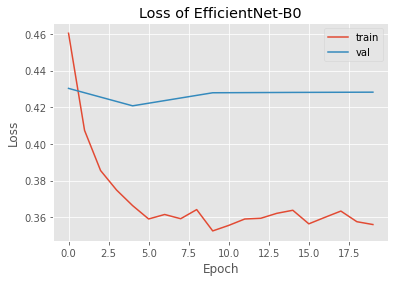

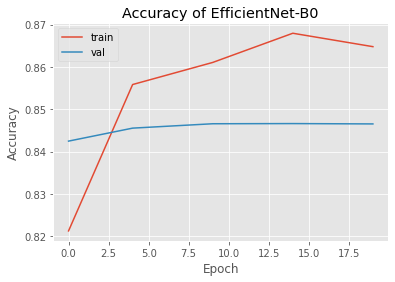

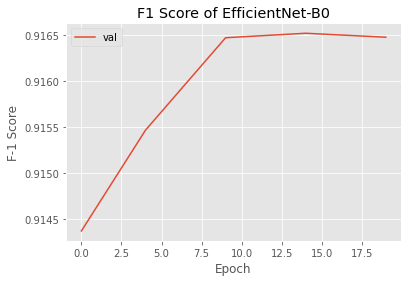

In [39]:
eff_train_losses = train_losses
eff_train_accuracy_list = train_accuracy_list
eff_test_losses = test_losses
eff_test_accuracy_list = test_accuracy_list
eff_test_precision_list = test_precision_list
eff_test_recall_list = test_recall_list
eff_test_f1_list = test_f1_list
plot_losses(eff_train_losses, eff_test_losses, test_interval, num_epochs,"Loss of EfficientNet-B0")
plot_accuracy(eff_train_accuracy_list, eff_test_accuracy_list, test_interval, num_epochs,"Accuracy of EfficientNet-B0")
plot_F1(eff_test_f1_list, test_interval, num_epochs, "F1 Score of EfficientNet-B0")

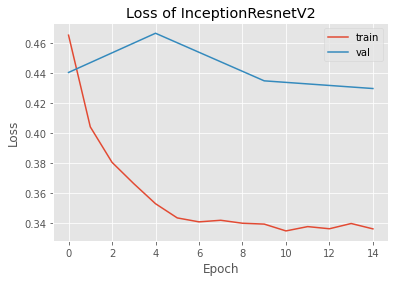

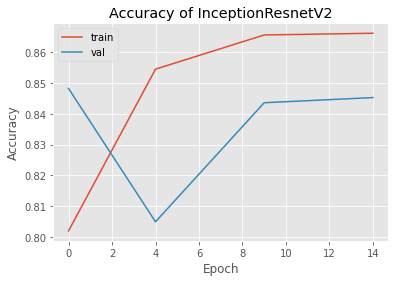

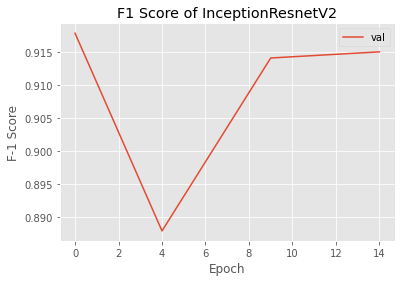

In [46]:
res_train_losses = train_losses
res_train_accuracy_list = train_accuracy_list
res_test_losses = test_losses
res_test_accuracy_list = test_accuracy_list
res_test_precision_list = test_precision_list
res_test_recall_list = test_recall_list
res_test_f1_list = test_f1_list
plot_losses(res_train_losses, res_test_losses, test_interval, num_epochs,"Loss of InceptionResnetV2")
plot_accuracy(res_train_accuracy_list, res_test_accuracy_list, test_interval, num_epochs,"Accuracy of InceptionResnetV2")
plot_F1(res_test_f1_list, test_interval, num_epochs, "F1 Score of InceptionResnetV2")

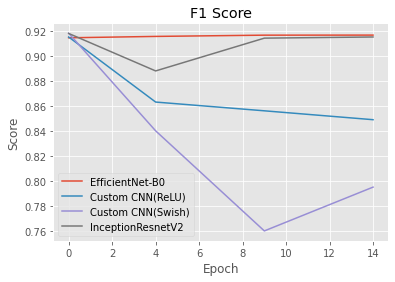

In [116]:
indices = [i for i in range(num_epochs) if ((i+1)%5 == 0 or i ==0)]
plt.plot(indices, eff_test_f1_list[:4], label="EfficientNet-B0")
plt.plot(indices, cus1_test_f1_list, label="Custom CNN(ReLU)")
plt.plot(indices, cus2_test_f1_list, label="Custom CNN(Swish)")
plt.plot(indices, res_test_f1_list[:4], label="InceptionResnetV2")
plt.ylabel("Score")
plt.xlabel("Epoch")
plt.legend()
plt.title("F1 Score")
plt.show()

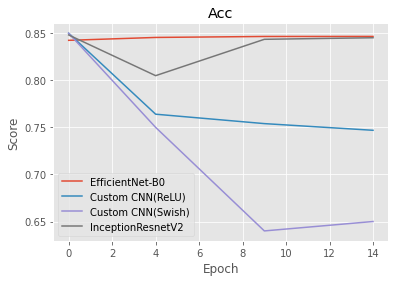

In [113]:
indices = [i for i in range(num_epochs) if ((i+1)%5 == 0 or i ==0)]
plt.plot(indices, eff_test_accuracy_list[:4], label="EfficientNet-B0")
plt.plot(indices, cus1_test_accuracy_list, label="Custom CNN(ReLU)")
plt.plot(indices, cus2_test_accuracy_list, label="Custom CNN(Swish)")
plt.plot(indices, res_test_accuracy_list[:4], label="InceptionResnetV2")
plt.ylabel("Score")
plt.xlabel("Epoch")
plt.legend()
plt.title("Acc")
plt.show()

In [70]:
import random
def eval_example(model, dirs):
    model.eval()
    image_path = random.choice(dirs)+'0.jpg'
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.grid(False)
    image = image.resize((224, 224))
    image = train_transforms(image).unsqueeze(0).to(device)
    output = model(image)
    pred = torch.sigmoid(output).item()
    if pred>0.5:
        plt.title('Prediction: FAKE')
    else:
        plt.title('Prediction: REAL')
    plt.show()
    print(output.item())

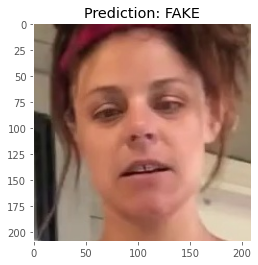

0.8128197193145752


In [80]:
f = eval_example(model, fake_dirs)

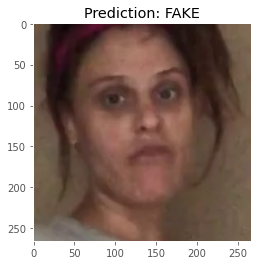

0.620008647441864


In [102]:
r = eval_example(model, real_dirs)